# **Modeling and Evaluation **

## Objectives

* Fit and evaluate a regression model to predict sale prices of inherited houses

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csv
* Instructions on which variables to use for data cleaning and feature engineering, found in data cleaning and feature engineering notebooks.


## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PriceProphet-PP5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/PriceProphet-PP5'

---

# ML Pipeline: Regressor

## Step1: Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePrices.csv") 

print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


## Step 2: ML Pipeline

### Import necessary libraries

In [25]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer

### Feature Engineering
from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

### ML pipeline for Data Cleaning and Feature Engineering

* We create a pipeline using data cleaning and feature engineering notebooks

In [32]:
# Pipeline optimization
def PipelineOptimization(model):
  pipeline_base = Pipeline([
        # Data cleaning (copied from Data Cleaning notebook)
      ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['LotFrontage' , 'BedroomAbvGr']) ),
      ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['2ndFlrSF', 'MasVnrArea']) ),
      ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='None',
                                     variables=['GarageFinish' , 'BsmtFinType1', 'BsmtExposure']) ),
      ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'GarageYrBlt', 'WoodDeckSF']) ),

        # Feature engineering (copied from Feature Engineering notebook)
    ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'] ) ),
    
    ('logT', vt.LogTransformer(variables = ['GrLivArea', 'LotArea', 'LotFrontage', '1stFlrSF']) ),

    ('powerT', vt.PowerTransformer(variables = ['GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF','2ndFlrSF']) ),
      
    ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                                  variables=['GrLivArea',
                         'LotArea',
                         'LotFrontage',
                         'GarageArea',
                         'MasVnrArea', 
                         'OpenPorchSF',
                         'TotalBsmtSF',
                         '1stFlrSF',
                         '2ndFlrSF']) ),      
       
    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables= None,
       method="spearman", threshold=0.6,selection_method="variance") ),
    ("feat_scaling", StandardScaler() ),
    ("feat_selection",  SelectFromModel(model) ),
    ("model", model ),
    ])

  return pipeline_base

### Custom Class for hyperparameter Optimization

(Code copied from walk through project prepared by Code Institute)

In [33]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches



### Split Train Test Set

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1) ,
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


### Grid Search CV - Sklearn
Use standard hyperparameters to find most suitable algorithm

In [38]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LinearRegression": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [39]:
from sklearn.metrics import make_scorer, recall_score

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [40]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.665815,0.769734,0.818507,0.056908
2,RandomForestRegressor,0.651773,0.758653,0.828425,0.059057
5,GradientBoostingRegressor,0.584794,0.739763,0.838969,0.084992
0,LinearRegression,0.656724,0.718054,0.758578,0.037436
6,XGBRegressor,0.538758,0.668559,0.797551,0.088973
4,AdaBoostRegressor,0.496399,0.647509,0.707191,0.076817
1,DecisionTreeRegressor,0.399741,0.526565,0.661377,0.083069


### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

In [41]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}

Extensive GridSearch CV

In [42]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [43]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.658724,0.769975,0.814568,0.057985,None,1,2,50
1,ExtraTreesRegressor,0.665815,0.769734,0.818507,0.056908,None,1,2,100
2,ExtraTreesRegressor,0.665675,0.769135,0.813976,0.056911,None,1,2,150
25,ExtraTreesRegressor,0.656763,0.765687,0.81847,0.061888,15,1,2,100
26,ExtraTreesRegressor,0.658335,0.765465,0.81642,0.059882,15,1,2,150
4,ExtraTreesRegressor,0.704459,0.764832,0.812889,0.045964,None,1,50,100
28,ExtraTreesRegressor,0.704459,0.764795,0.812978,0.046148,15,1,50,100
3,ExtraTreesRegressor,0.701603,0.764555,0.814408,0.046545,None,1,50,50
27,ExtraTreesRegressor,0.701603,0.764131,0.814586,0.046535,15,1,50,50
29,ExtraTreesRegressor,0.702095,0.763948,0.810724,0.045205,15,1,50,150


In [44]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [45]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [46]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr'])),
                ('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'MasVnrArea'])),
                ('categorical',
                 CategoricalImputer(fill_value='None',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'BsmtExposure'])),
                ('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'GarageY...
                                       'GarageArea', 'MasVnrArea',
                                       'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF',
                                       '2ndFlrSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(n_estimators=50, random_state=0))])

* These are the 6 most important features in descending order. The model was trained on them: 
['TotalBsmtSF', 'GarageArea', 'YearBuilt', '2ndFlrSF', 'YearRemodAdd', 'KitchenQual']


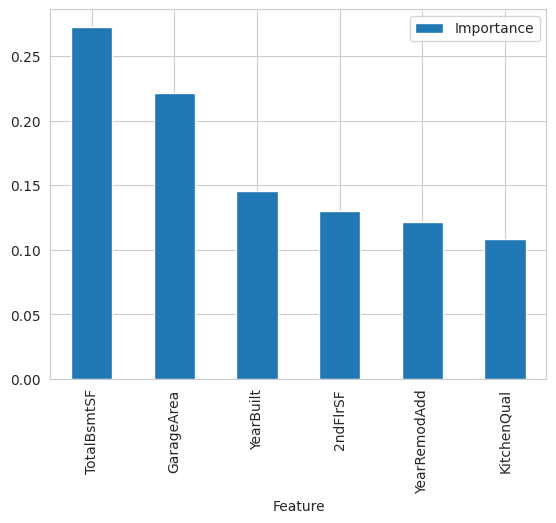

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 9 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps]).transform(X_train).columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets

In [49]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  plt.savefig(f'docs/plots/regression_performance.png', bbox_inches='tight')  
  plt.show()

We agreed with the client an R2 score of at least 0.75 on the train set as well as on the test set.

Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 130.241
Mean Squared Error: 855959.757
Root Mean Squared Error: 925.181


* Test Set
R2 Score: 0.815
Mean Absolute Error: 22229.715
Mean Squared Error: 1276933332.221
Root Mean Squared Error: 35734.204




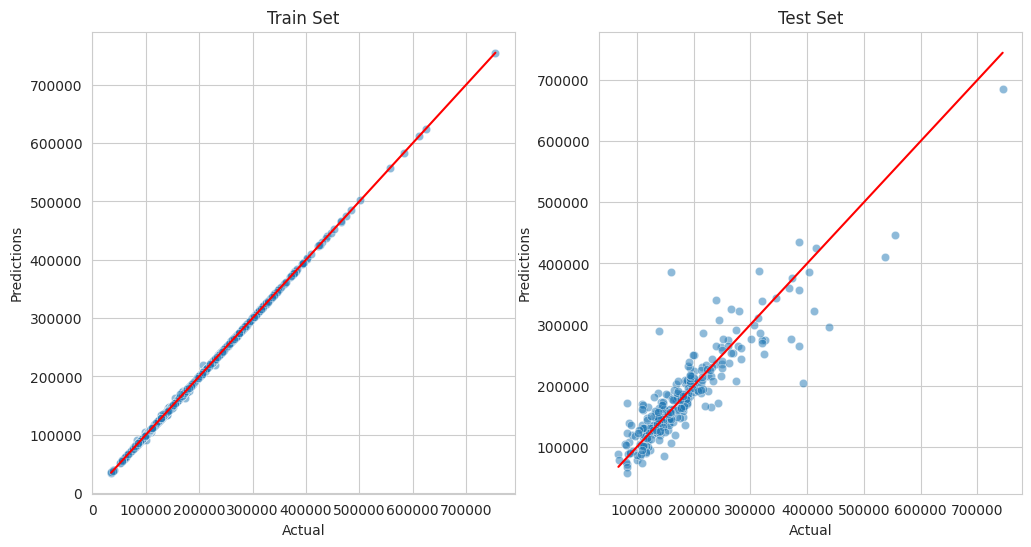

In [50]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## 3. Refit pipeline with best features

In [51]:
best_features

['2ndFlrSF',
 'GarageArea',
 'KitchenQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

In [55]:
def PipelineOptimization(model):
    pipeline_base = Pipeline(steps=[  
    ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['2ndFlrSF']) ),
    ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['KitchenQual']) ),

    ('powerT', vt.PowerTransformer(variables = ['TotalBsmtSF', 'GarageArea']) ),
      
    ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                                  variables=['2ndFlrSF', 'TotalBsmtSF', 'GarageArea']) ),      

    ("feat_scaling", StandardScaler() ),

  ('model', ExtraTreesRegressor(max_depth='None', min_samples_split=2, min_samples_leaf= 1, n_estimators=50, random_state=0))])        
    return pipeline_base

### Split Train Test Set, only with best features

In [56]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 6) (1168,) 
* Test set: (292, 6) (292,)


,2ndFlrSF,GarageArea,KitchenQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,0.0,774,Gd,1822,2007,2007
870,0.0,308,TA,894,1962,1962
92,0.0,432,TA,876,1921,2006


## Grid Search CV: Sklearn

In [57]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [58]:
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [59]:
params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [50],
        'model__max_depth': [None],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1],
    },
}

### GridSearch CV

In [60]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Check results

In [61]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.70045,0.7663,0.8065,0.040283,None,1,2,50


In [62]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [64]:
best_pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
best_pipeline_regressor


Pipeline(steps=[('median', MeanMedianImputer(variables=['2ndFlrSF'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('powerT',
                 PowerTransformer(variables=['TotalBsmtSF', 'GarageArea'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['2ndFlrSF', 'TotalBsmtSF',
                                       'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(n_estimators=50, random_state=0))])

---

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [65]:
import joblib
import os

version = 'v4'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [66]:
X_train.head()

,2ndFlrSF,GarageArea,KitchenQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,0.0,774,Gd,1822,2007,2007
870,0.0,308,TA,894,1962,1962
92,0.0,432,TA,876,1921,2006
817,0.0,857,Gd,1568,2002,2002
302,0.0,843,Gd,1541,2001,2002


In [67]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)


In [68]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)


In [69]:
X_test.head()

,2ndFlrSF,GarageArea,KitchenQual,TotalBsmtSF,YearBuilt,YearRemodAdd
529,0.0,484,TA,2035,1957,1975
491,620.0,240,Fa,806,1941,1950
459,224.0,352,Gd,709,1950,1950
279,866.0,505,TA,1160,1977,1977
655,NaN,264,TA,525,1971,1971


In [70]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)


In [71]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [72]:
best_pipeline_regressor

Pipeline(steps=[('median', MeanMedianImputer(variables=['2ndFlrSF'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('powerT',
                 PowerTransformer(variables=['TotalBsmtSF', 'GarageArea'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['2ndFlrSF', 'TotalBsmtSF',
                                       'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(n_estimators=50, random_state=0))])

In [73]:
joblib.dump(value=best_pipeline_regressor, filename=f"{file_path}/regression_pipeline.pkl")


['outputs/ml_pipeline/predict_price/v4/regression_pipeline.pkl']

## Feature importance plot

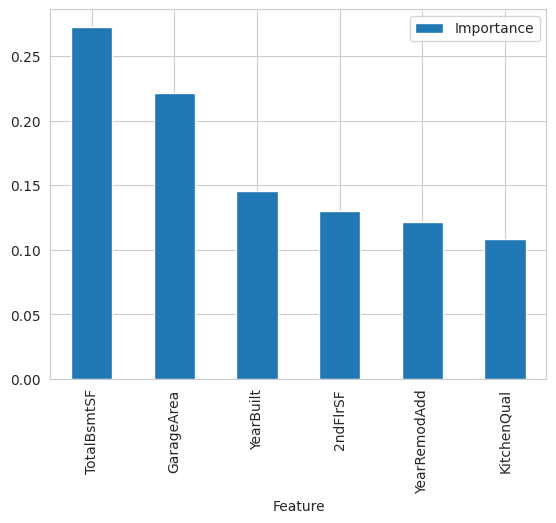

In [74]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

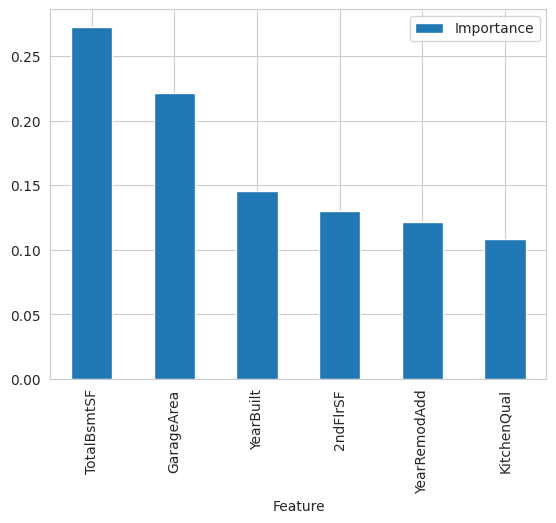

In [75]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')
## Save to docs folder for documentation
plt.savefig(f'docs/plots/features_importance.png', bbox_inches='tight') 

## Conclusions